In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle
from matplotlib.pyplot import figure
%matplotlib inline
import warnings
from IPython.display import Image
from collections import Counter
import random

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

In [3]:
csv_file = 'data/HeartRateData.csv'
df_raw = pd.read_csv(csv_file)
df_raw=df_raw.drop('DateTime',1)
df_raw.head(3)

,BPM
0,77
1,69
2,69


In [4]:
print (round(df_raw.BPM.describe()))

count    349768.0
mean         78.0
std          24.0
min          30.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64


In [37]:
df_s=random.sample(list(df_raw.BPM), 40000)

df_sample = pd.DataFrame(df_s)
df_sample.columns=['BPM']


print (round(df_sample.describe()))

           BPM
count  40000.0
mean      78.0
std       24.0
min       33.0
25%       61.0
50%       69.0
75%       86.0
max      215.0


In [38]:
def zones(age):
    max_hr = 220 - age
    target_low = 0.64*max_hr
    target_high = 0.76*max_hr
    target_intensity_lo = 0.76*max_hr
    target_intensity_hi = 0.93*max_hr
    print ("For Age: {} Maximum HR: {}".format(age,max_hr))
    print ("Target HR Lower Bound:", target_low)
    print ("Target HR Upper Bound:", target_high)
    print ("Target HR Intensity Upper Bound:", target_intensity_hi)
    return max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi

In [39]:
max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi = zones(62)

For Age: 62 Maximum HR: 158
Target HR Lower Bound: 101.12
Target HR Upper Bound: 120.08
Target HR Intensity Upper Bound: 146.94


In [40]:
def plot_data_histo(totals): 
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']
    plt.figure(figsize=(10,5))
    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    #plt.figure(figsize=(10,5))
    plt.grid(True)
    bin=100
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()
    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Raw Heart Rate Distribution')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    plt.hist(df_raw.BPM, bins=range(35, 205+2, 2))
    plt.savefig('./plots/raw_histo.png')
    plt.show()

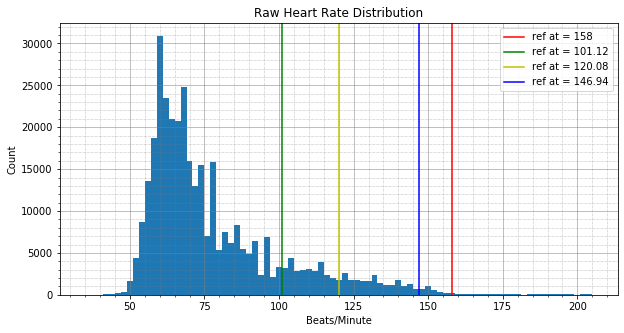

In [41]:
plot_data_histo(df_sample)

In [42]:
def hr_cluster_histogram(df): 
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=5)
    model = kmeans.fit(df)
    centers = np.round(model.cluster_centers_,0)
    print ("\nCluster {}: {}".format(k,centers))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)

    clusterCounts(labels)
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    #for ref, c in zip(xref,ref_colors):
    #    plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        
    zone1 = df.loc[df.Label ==0, 'BPM']
    zone2 = df.loc[df.Label ==1, 'BPM']
    zone3 = df.loc[df.Label ==2, 'BPM']
    zone4 = df.loc[df.Label ==3, 'BPM']
    zone5 = df.loc[df.Label ==4, 'BPM']
    
    
    plt.figure(figsize=(10,5))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    bin = 20
    
    #plt.grid(True)
    plt.title('Cluster Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='b', label='Cluster 1', bins=range(35, 205, 2))
    plt.hist(zone2, **kwargs, color='c', label='Cluster 2', bins=range(35, 205, 2))
    plt.hist(zone3, **kwargs, color='g', label='Cluster 3', bins=range(35, 205, 2))
    plt.hist(zone4, **kwargs, color='y', label='Cluster 4', bins=range(35, 205, 2))
    plt.hist(zone5, **kwargs, color='r', label='Cluster 5', bins=range(35, 205, 2))
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    #plt.xlim(30,200)
    #plt.hist(df_raw.BPM, bins=range(35, 205, 2))
    plt.legend()
    plt.savefig('./plots/cluster_histo.png')
    plt.show()

In [76]:
def hr_zone_histogram(df): 
    
    clusterCounts(df['Polar_Zone'])
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    #for ref, c in zip(xref,ref_colors):
    #    plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
        
    zone1 = df.loc[df.Polar_Zone == 'zone1', 'BPM']
    zone2 = df.loc[df.Polar_Zone == 'zone2', 'BPM']
    zone3 = df.loc[df.Polar_Zone == 'zone3', 'BPM']
    zone4 = df.loc[df.Polar_Zone == 'zone4', 'BPM']
    zone5 = df.loc[df.Polar_Zone == 'zone5', 'BPM']
    
    
    plt.figure(figsize=(10,5))
    # xticks = np.linspace(30, 200, 50)
    kwargs = dict(alpha=0.5)
    plt.xticks(np.arange(20, 205, 20))
    plt.grid(b=True, which='both', color='0.65', linestyle='-')
    
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='grey')
    
    bin = 20 
    
    #plt.grid(True)
    plt.title('Zone Heart Rate Distribution')
    plt.hist(zone1, **kwargs, color='g', label='Zone 1',bins=bin)
    plt.hist(zone2, **kwargs, color='b', label='Zone 2',bins=bin)
    plt.hist(zone3, **kwargs, color='r', label='Zone 3',bins=bin)
    plt.hist(zone4, **kwargs, color='c', label='Zone 4',bins=bin)
    plt.hist(zone5, **kwargs, color='y', label='Zone 5',bins=bin)
    plt.ylabel('Counts')
    plt.xlabel('Beats Per Minute (BPM)')
    #plt.ylim(0,35000)
    plt.xlim(30,200)
    plt.legend()
    plt.savefig('./plots/zone_histo.png')
    plt.show()

In [43]:
hardware_limit = 210
df_limit = df_sample[(df_sample < hardware_limit)]
num_screened = df_sample.shape[0]-df_limit.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 0 data points.


 Note that with KMeans clustering the data will not be split into training and test sets. Kmeans clustering is not a classification tool. The data is not labeled.

In [44]:

def scree_KMeans_plot(data,num_clusters):
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        print ("Cluster Labels: ",np.unique(labels))
        score = -(kmeans.score(data))
        print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('./plots/Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels


Cluster 1: [[77.73615]]
Cluster Labels:  [0]
score:  0.22

Cluster 2: [[ 67.81352542]
 [117.42044744]]
Cluster Labels:  [0 1]
score:  0.07

Cluster 3: [[ 88.03384904]
 [129.16100629]
 [ 63.27974761]]
Cluster Labels:  [0 1 2]
score:  0.04

Cluster 4: [[ 61.99775023]
 [106.41608263]
 [141.47667984]
 [ 80.26986755]]
Cluster Labels:  [0 1 2 3]
score:  0.02

Cluster 5: [[104.74381163]
 [ 61.99775023]
 [ 80.2088267 ]
 [134.02098151]
 [191.55454545]]
Cluster Labels:  [0 1 2 3 4]
score:  0.02

Cluster 6: [[ 59.56278952]
 [109.82087379]
 [136.7545376 ]
 [ 87.78423237]
 [ 71.55337748]
 [192.06481481]]
Cluster Labels:  [0 1 2 3 4 5]
score:  0.01

Cluster 7: [[ 69.13708679]
 [114.94115691]
 [138.53548387]
 [ 58.90922661]
 [ 96.25708008]
 [192.31775701]
 [ 81.06555228]]
Cluster Labels:  [0 1 2 3 4 5 6]
score:  0.01

Cluster 8: [[126.32914704]
 [ 67.01854073]
 [ 90.89675252]
 [145.05      ]
 [ 57.96977222]
 [108.05269646]
 [194.3030303 ]
 [ 77.51436869]]
Cluster Labels:  [0 1 2 3 4 5 6 7]
score:  0

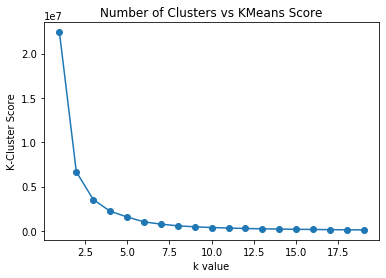


Function in 0.1 minutes


In [45]:

k_values, scores, labels = scree_KMeans_plot(df_sample,20) 
k = zip(k_values, scores)
print (k)

In [47]:
#for score in scores:
    #print (round(score/100000000,2))

def findK(df,limit): 
    print ("Maximum value of number of clusters (k) is: ",len(df))
    for k in range(len(df)):
 
        if k == len(df):
           print ("\nEnd of array reached.") 
        elif k == len(df): 
          improvement = 'None'
          print ("end of array reached prior to limit")
          print ("K=0")
        elif k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                #print ("Improvement of {}% is less than lower limit of {}% for k = {}. k max is {} ".format(improvement,limit,k,len(df)))
                break
    print ("Less than {}% improvement in score after k = {}".format(limit,k))

findK(scores,15) 

Maximum value of number of clusters (k) is:  19
1 0.07 236.0
2 0.04 89.0
3 0.02 60.0
4 0.02 41.0
5 0.01 55.0
6 0.01 35.0
7 0.01 32.0
8 0.0 24.0
9 0.0 22.0
10 0.0 19.0
11 0.0 19.0
12 0.0 15.0
13 0.0 17.0
14 0.0 15.0
15 0.0 9.0
Less than 15% improvement in score after k = 15


In [48]:
print ("KMeans Labels: ",np.unique(labels))     

KMeans Labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


In [49]:
def clusterCounts(labels): 
    #Count number in each cluster for general population 
    clusterDict = collections.Counter(labels)
    clusterSum = sum(clusterDict.values())
    #clusterCounter = Counter(clusterDict.values())

    for key,value in sorted(clusterDict.items()): 
        print (key, ' ->',np.round(100*value/clusterSum),'%')


Cluster <zip object at 0x7f8ad31285c8>: [[102.]
 [ 61.]
 [132.]
 [ 78.]
 [190.]]
KMeans Labels:  [0 1 2 3 4]
0  -> 14.0 %
1  -> 51.0 %
2  -> 8.0 %
3  -> 26.0 %
4  -> 1.0 %


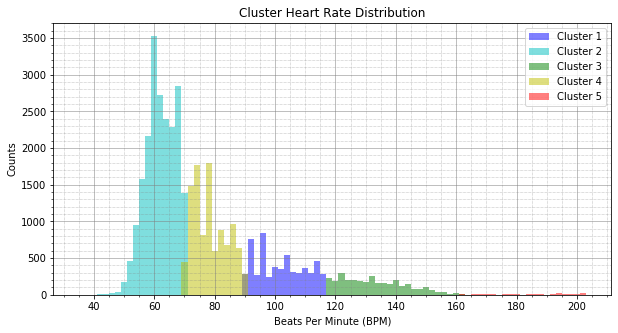

In [50]:
hr_cluster_histogram(df_sample)

In [51]:
#Image('./plots/cluster_histo.png')

In [52]:
def assignZone(value):
    if (value) <= zone1: 
        return"zone1"
    elif (value > zone1) and (value <= zone2):
        return "zone2"
    elif (value > zone2) and (value <= zone3):
        return  "zone3"
    elif (value > zone3) and (value <= zone4):
        return  "zone4"    
    elif (value > zone4) and (value <= zone5):
        return "zone5"
    else:
        return 'nan'
        print ('\nvalue is nan: ',value)
   

In [54]:
zone1 = 0.6 * (220-63) 
zone2 = 0.7 * (220-63) 
zone3 = 0.8 * (220-63)
zone4 = 0.9 * (220-63)
zone5 = 1.0 * (220-63)
print ("Zone Upper Limits: zone1: {}, zone2: {}, zone3: {}, zone4: {}, zone5: {}".format(zone1,round(zone2),round(zone3),zone4,zone5))

Zone Upper Limits: zone1: 94.2, zone2: 110, zone3: 126, zone4: 141.3, zone5: 157.0


In [55]:
df_zones=df_sample.copy()
df_zones['Polar_Zone'] = df_zones.BPM.apply(assignZone)
print (df_zones.shape)
df_zones.head()

(40000, 3)


,BPM,Label,Polar_Zone
0,64,1,zone1
1,69,1,zone1
2,72,3,zone1
3,72,3,zone1
4,83,3,zone1


In [56]:
#Checking for Zone assignment: 
df_zones['Polar_Zone'].unique()

array(['zone1', 'zone4', 'nan', 'zone2', 'zone3', 'zone5'], dtype=object)

In [57]:
df2 = df_zones.copy() 
print ("df2 shape: \n",df2.shape)
clusterCounts(df2['Polar_Zone'])
#display (df2.groupby('Polar_Zone').count())
#display (df.groupby('Label').count())

df2 shape: 
 (40000, 3)
nan  -> 1.0 %
zone1  -> 81.0 %
zone2  -> 8.0 %
zone3  -> 6.0 %
zone4  -> 4.0 %
zone5  -> 2.0 %


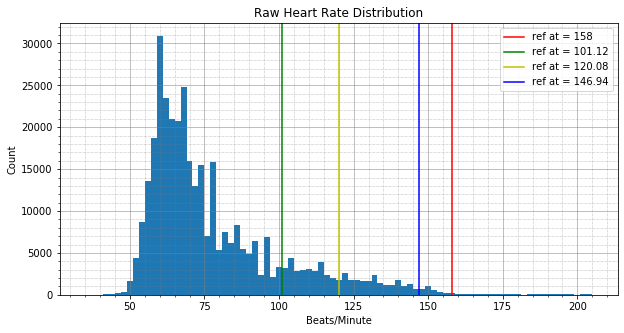

In [59]:
plot_data_histo(df_sample.BPM)

In [60]:
df2.head()

,BPM,Label,Polar_Zone
0,64,1,zone1
1,69,1,zone1
2,72,3,zone1
3,72,3,zone1
4,83,3,zone1


nan  -> 1.0 %
zone1  -> 81.0 %
zone2  -> 8.0 %
zone3  -> 6.0 %
zone4  -> 4.0 %
zone5  -> 2.0 %


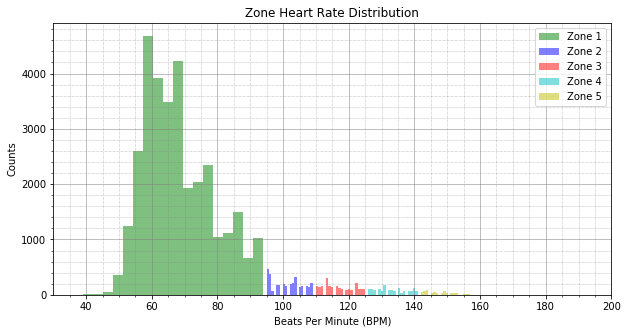

In [77]:
hr_zone_histogram(df2)

In [ ]:
Image('./plots/raw_histo.png')

In [ ]:
Image('./plots/cluster_histo.png')

In [ ]:
Image('./plots/zone_histo.png')

In [62]:
print (df2.head())
df2.BPM.head()


   BPM  Label Polar_Zone
0   64      1      zone1
1   69      1      zone1
2   72      3      zone1
3   72      3      zone1
4   83      3      zone1


0    64
1    69
2    72
3    72
4    83
Name: BPM, dtype: int64

In [81]:

def silhouetteScore(df,num_clusters): 
    sil_scores = [] 
    start = timer()
    range_n_clusters = list(range(2,num_clusters))
    for n_clusters in range_n_clusters:
        #kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        kmeans = KMeans(n_clusters=n_clusters)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        sil_scores.append(score)
        print("\nFor n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        print(f"Function in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores

In [85]:
%%time
sil_scores = silhouetteScore(df2.BPM.values.reshape(-1,1),num_clusters)

   BPM  Label Polar_Zone
0   64      1      zone1
1   69      1      zone1
2   72      3      zone1
3   72      3      zone1
4   83      3      zone1
[[64]
 [69]
 [72]
 ...
 [59]
 [68]
 [60]]

For n_clusters = 2, silhouette score is 0.7019536815859312
Function in 0.4 minutes

Finished!
CPU times: user 20.6 s, sys: 2.78 s, total: 23.4 s
Wall time: 23.4 s


In [66]:
#pickle.dump(sil_scores,open('data/silhouetteScores','wb'))
silhouette = pickle.load(open('data/silhouetteScores', 'rb'))
print ("Sil Scores: ",silhouette)

Sil Scores:  [0.7019536815859312, 0.6147305730470606, 0.5854387570593567, 0.5873391956080526, 0.567917391844778, 0.5562202011210109, 0.5537230074225479, 0.5577654335791888, 0.5514605559203648, 0.5564664141356312, 0.5433096404868549, 0.545879403770531, 0.5697131501461868]


In [67]:
def silhouette_plot(scores, k_values):

    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')
    plt.show()

In [72]:
print (len(k_values), len(silhouette))
print (oftype(k_values))
print (oftype(silhouette))
if len(k_values) > len(silhouette):
    k_values = k_values[:-1]
oftype(k_values)
print (len(k_values), len(silhouette))

14 13
None
None
13 13


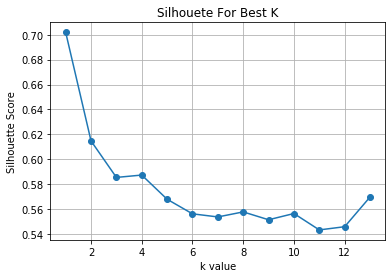

In [73]:
silhouette_plot(silhouette,k_values)

In [ ]:
def clusters_plot(df,num_clusters):
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=num_clusters)
    model = kmeans.fit(df)
    print ("\nCluster {}: {}".format(k,model.cluster_centers_))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)
 
    cluster0 = df.loc[df['Label'] == 0]
    cluster1 = df.loc[df['Label'] == 1]
    
    print ("cluster0.shape: ",cluster0.shape)
    print ("cluster1.shape: ",cluster1.shape)
    #print (cluster0.head())
    #print (cluster1.head())
    
    bins = np.linspace(30, 200, 50)
    plt.subplot(2,1,1)
    plt.hist(cluster0.BPM,bins)
    plt.title('Heart Rate Distribution for 2 Clusters')
  
    plt.grid(True)
    plt.ylabel('Cluster 0')
    
    plt.subplot(2,1,2)
    plt.hist(cluster1.BPM,bins) 
    plt.xlabel('Beats Per Minute')
    plt.ylabel('Cluster 1')
    plt.grid(True)
    plt.show()
        
#clusters_plot(df,2)

In [ ]:
Image('./plots/raw_histo.png')
Image('./plots/cluster_histo.png')
Image('./plots/zone_histo.png')

The first step in determining high intensity heart rate zones is to determine maximum heart rate. There are several methods for this: 

1. 200 - 1/2 age. Or 168bpm for a 62 year old. 
2. 220 - age. 0r 158bpm for a 62 year old.
3. Heart Rate Monitor data collected over a period of months with various activities. 
4. Using a treadmill or stationary bike with an ECG. 

Option number 2 is the most common for folks that do not have access to the treadmill and ECG. It will be used for the remainder of the project. 

After the maximum heart rate is determined, target heart rates can be determined: 
1. Target active heart rate: 60-70%. Or 95 to 110 bpm for the 62 year old. 
2. Target Heart Rate is 64% to 76%. CDC. 
3. High Intensity target heart rate is 76-93% (CDC). Or 120 to 146 for the 62 year old. 
 
The heart rate monitor company Polar suggests 5 heart rate zones: 
1. Very light at 50-60% of HRMAX. Boost recovery and prepare for higher zones.
2. Light 60-70%. Improve general endurance and increase capillary density.
2. Moderate at 70-80%. Lactic acid build up,improve efficiency of blood circulation in the heart and muscles
4. Hard 80-90%. Improve speed endurance.
5. Maximum 90-100%. For elite atheletes to further improve speed. 